# Environment setup and data import

## Environment setup

This is a view on the github-stored notebook. clone it first and navigate to a subfolder in orde to access the data files

In [1]:
! git clone https://github.com/slaninam/Loc1D.git

fatal: destination path 'Loc1D' already exists and is not an empty directory.


In [3]:
cd Loc1D

/content/Loc1D


## Data preprocessing

All input files are read into a single pandas DataFrame.
The naming convention is maintained, one additional column 'dist' is added to record the actual distance at which the measurement was taken.

The complete preprocessed data is available in the DataFrame **df**


In [0]:
import pandas as pd
import numpy as np

dists = np.arange(0, 35.5, 0.5)
dfs = []
for dist in dists:
    if dist.is_integer():
        fname = 'data/dist.' + '{0:.0f}'.format(dist) + 'm.txt'
    else:
        fname = 'data/dist.' + '{0:.1f}'.format(dist) + 'm.txt'
    
    df = pd.read_csv(fname, header = None, names=['time','tag id','anchor id','anchor1 id', 'anchor2 id', 'anchor3 id','a0ch0','a0ch1','a0ch2','a0ch3','a0rssi0','a0rssi1','a0rssi2','a0rssi3','a1ch0','a1ch1','a1ch2','a1ch3','a1rssi0','a1rssi1','a1rssi2','a1rssi3','a2ch0','a2ch1','a2ch2','a2ch3','a2rssi0','a2rssi1','a2rssi2','a2rssi3','a3ch0','a3ch1','a3ch2','a3ch3','a3rssi0','a3rssi1','a3rssi2','a3rssi3'])
    df['dist'] = dist
    dfs.append(df)

df = pd.concat(dfs)

## Train and test set creation
The data is randomly divided in the train and test sets and the target values are put in separate vectors. 

Potentially leaky variables removed:
* 'time'

Othev variables removed as they contain no value:
* 'tag id'
* 'anchor id'
* 'anchor1 id'
* 'anchor2 id'
* 'anchor3 id'

In [0]:
from sklearn.model_selection import train_test_split

df = df.drop(axis=1,labels = ['time'])
df = df.drop(axis=1,labels = ['tag id','anchor id','anchor1 id','anchor2 id','anchor3 id'])

X_train, X_test, y_train, y_test = train_test_split(df.drop(axis=1,labels = ['dist']), df['dist'], test_size=0.3, random_state=0)


# Models



## ANN
* Multi-Layer Perceptron
* Totally random structure (first guess)
* Output F2-score 0.91 (=not bad)

In [6]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(40, 30), random_state=0)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9531834869657286

## Classifier performance metrics

Plotting the predicted distances vs real distances:

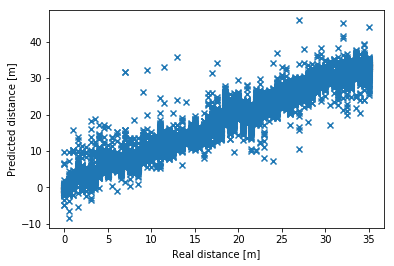

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

x = y_test
y = clf.predict(X_test)

plt.scatter(x,y,marker='x')
plt.xlabel('Real distance [m]')
plt.ylabel('Predicted distance [m]')
plt.show()

In [9]:
err = y-x
err.describe()

count    15091.000000
mean         0.025700
std          2.191961
min        -16.659808
25%         -1.176861
50%         -0.020850
75%          1.166256
max         24.798873
Name: dist, dtype: float64

In [0]:
srterr = sorted(abs(err))

In [11]:
srterr[13580]

3.2127221694425643

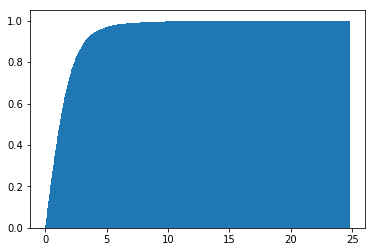

In [12]:
_=plt.hist(srterr, bins=1000, cumulative=True, density=True)